In [234]:
!pip install ucimlrepo

In [235]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [236]:
pd.set_option('display.max_columns', None)

In [237]:
# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
data = diabetes_130_us_hospitals_for_years_1999_2008.data.original
data

/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,MC,NaN,51,0,16,0,0,0,250.13,291,458,9,NaN,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,MC,NaN,33,3,18,0,0,1,560,276,787,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,53,0,9,1,0,0,38,590,296,13,NaN,NaN,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,45,2,21,0,0,1,996,285,998,9,NaN,NaN,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO


# Data Exploration
In the following, we want to get to know our dataset by looking at different features and plotting our findings.

This is what we want to look at:
* Sociodemographic data (age, gender, race, payer_code)
* Types of diagnoses
* Number of patients that are appear multiple times in the dataset (that are readmitted within the span of 1999-2008)
* Medication of patients with diabetes (in diag_1, diag_2 or diag_3)
* Diagnoses that occur together with Diabetes
* Target value 'readmitted'
* Correlation matrix

## Sociodemographic data

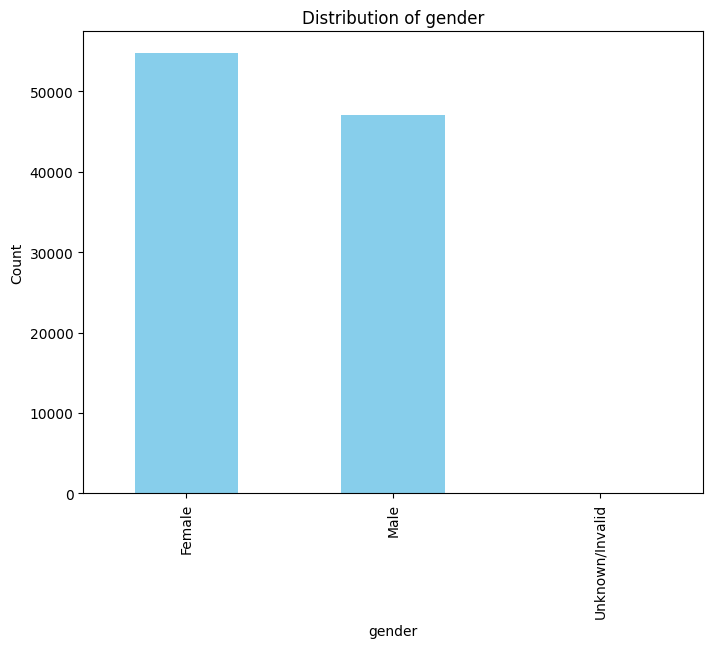

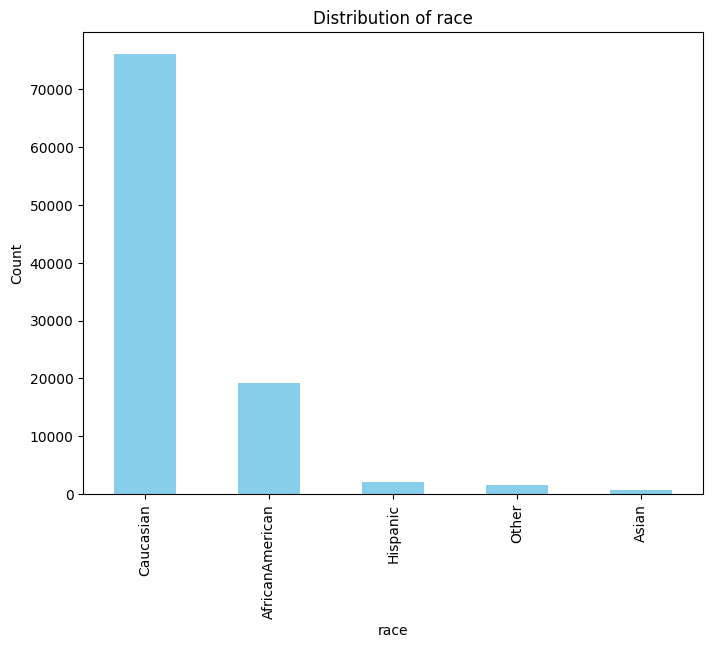

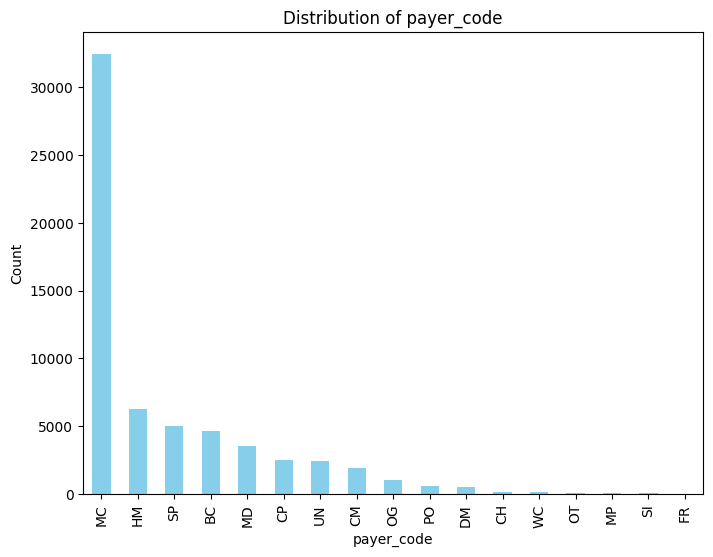

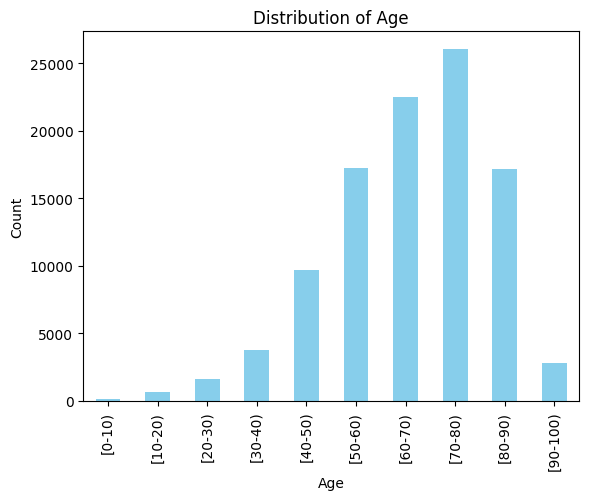

In [238]:
columns_to_plot = ["gender", "race", "payer_code"]

for column in columns_to_plot:
    data_counts = data[column].value_counts()

    plt.figure(figsize=(8, 6))
    data_counts.plot(kind='bar', color='skyblue')

    plt.ylabel('Count')
    plt.xlabel(column)
    plt.title(f'Distribution of {column}')

    plt.show()

# categories for age
age_categories = data["age"].unique()

data['age'] = pd.Categorical(data['age'], categories=age_categories, ordered=True)
data['age'].value_counts().sort_index().plot(kind='bar', color='skyblue')

plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Distribution of Age')

plt.show()


**NaN values**

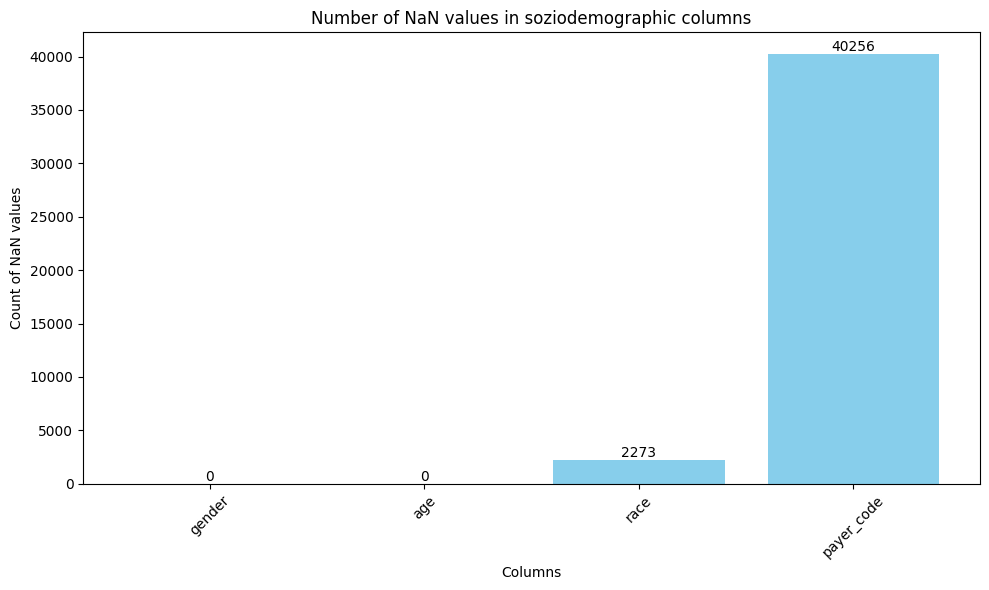

In [239]:
columns_to_plot = ["gender", "age", "race", "payer_code"]

# count nans
nan_counts = [data[column].isna().sum() for column in columns_to_plot]

# create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(columns_to_plot, nan_counts, color='skyblue')

for bar, count in zip(bars, nan_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom')

plt.ylabel('Count of NaN values')
plt.xlabel('Columns')
plt.title('Number of NaN values in soziodemographic columns')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

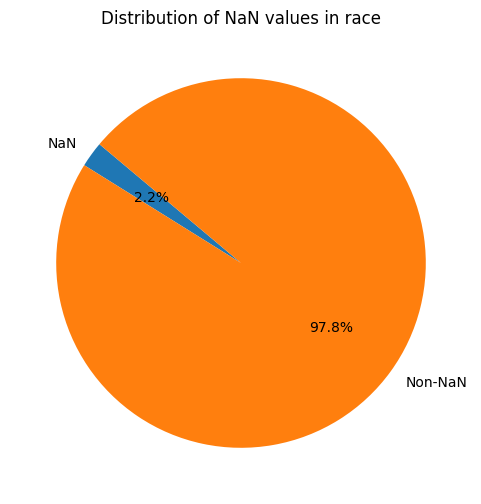

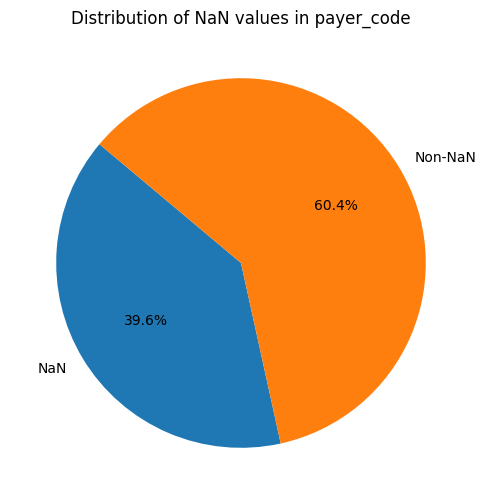

In [240]:
columns_to_check = ["race", "payer_code"]

# prepare data
nan_counts = [data[column].isna().sum() for column in columns_to_check]
non_nan_counts = [data[column].notna().sum() for column in columns_to_check]
labels = ['NaN', 'Non-NaN']

# create pie charts
for i, column in enumerate(columns_to_check):
    counts = [nan_counts[i], non_nan_counts[i]]

    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of NaN values in {column}')
    plt.show()


## Types of diagnoses
How often does a specific diagnosis occur?

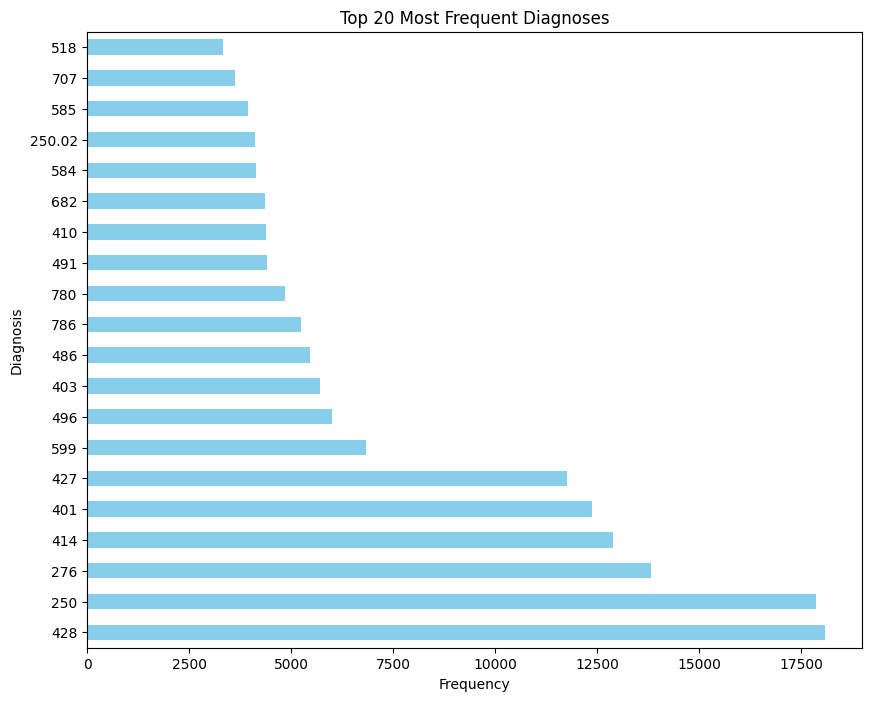

In [241]:
all_diagnoses = data['diag_1'].tolist() + data['diag_2'].tolist() + data['diag_3'].tolist()

# Zähle die Häufigkeit der einzigartigen Diagnosen
diagnoses_count = pd.Series(all_diagnoses).value_counts()

# Die 20 häufigsten Diagnosen auswählen
top_diagnoses = diagnoses_count.head(20)

# Plot der horizontalen Balkencharts für die Top-20-Diagnosen
plt.figure(figsize=(10, 8))
top_diagnoses.plot(kind='barh', color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Diagnosis')
plt.title('Top 20 Most Frequent Diagnoses')
plt.show()


In [242]:
def group_diagnosis(code):
    if pd.isnull(code):
        return "Missing"
    if code.startswith('250'):
        return 'Diabetes'
    if not code.isdigit():  # Überprüfen, ob der Code keine Zahl ist
        return 'Other'
    code = float(code)
    if 390 <= code <= 459 or code == 785:
        return 'Circulatory'
    elif 460 <= code <= 519 or code == 786:
        return 'Respiratory'
    elif 520 <= code <= 579 or code == 787:
        return 'Digestive'
    elif 800 <= code <= 999:
        return 'Injury'
    elif 710 <= code <= 739:
        return 'Musculoskeletal'
    elif 580 <= code <= 629 or code == 788:
        return 'Genitourinary'
    elif 140 <= code <= 239:
        return 'Neoplasms'
    else:
        return 'Other'

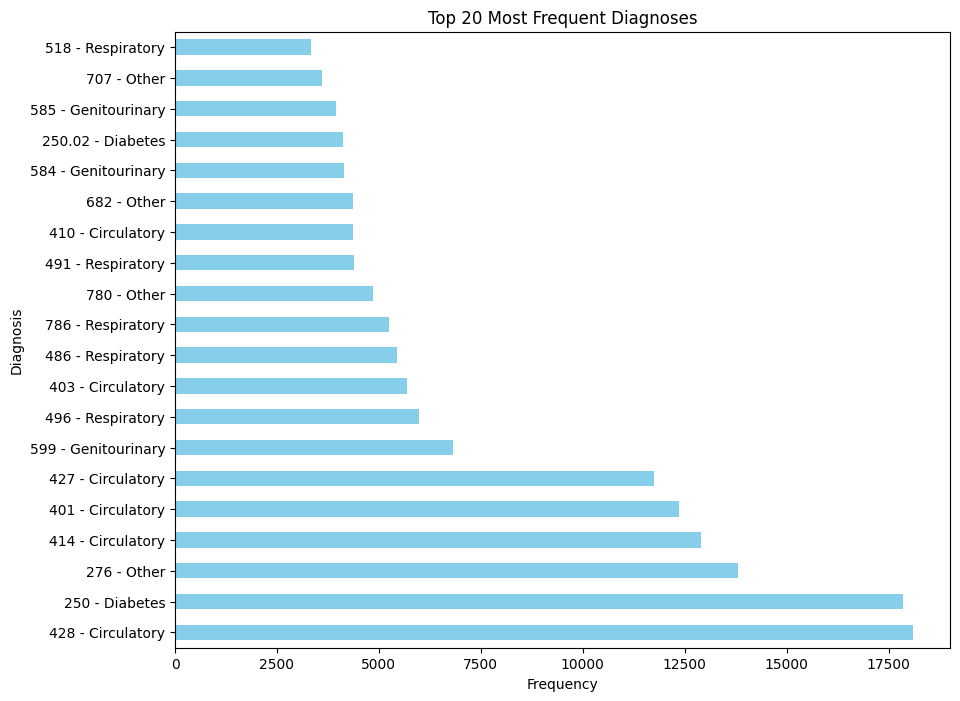

In [243]:
# Die 20 häufigsten Diagnosen auswählen
top_diagnoses = diagnoses_count.head(20)

# Liste von Beschriftungen erstellen
labels = []
for code, count in top_diagnoses.items():
    group = group_diagnosis(code)
    label = f"{code} - {group}"
    labels.append(label)

# Plot der horizontalen Balkencharts für die Top-20-Diagnosen mit angepassten Beschriftungen
plt.figure(figsize=(10, 8))
top_diagnoses.plot(kind='barh', color='skyblue')
plt.yticks(range(len(labels)), labels)  # Anpassen der Beschriftungen der y-Achse
plt.xlabel('Frequency')
plt.ylabel('Diagnosis')
plt.title('Top 20 Most Frequent Diagnoses')
plt.show()

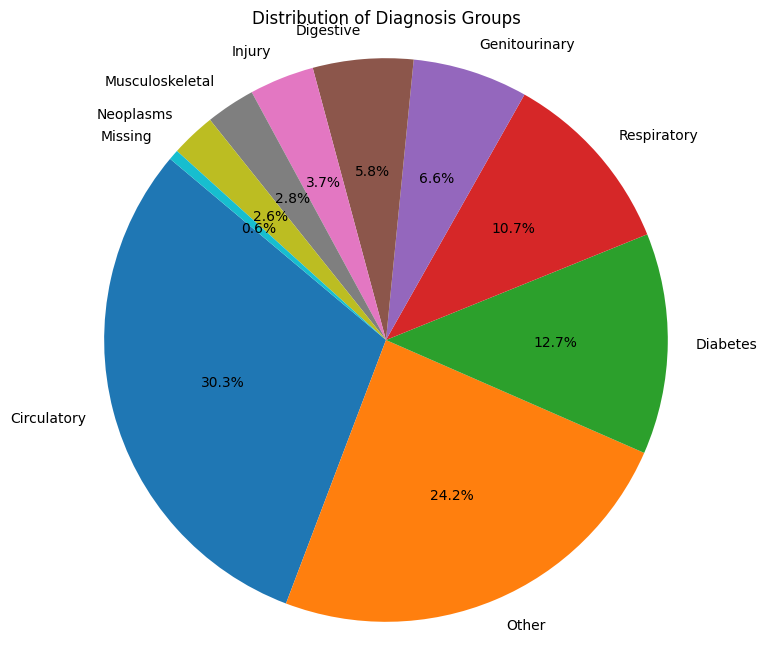

In [244]:
# Diagnosen in diag_1, diag_2 und diag_3 ersetzen
data['diag_1_grouped'] = data['diag_1'].apply(group_diagnosis)
data['diag_2_grouped'] = data['diag_2'].apply(group_diagnosis)
data['diag_3_grouped'] = data['diag_3'].apply(group_diagnosis)

# Diagnosen zählen
diagnosis_counts = pd.concat([data['diag_1_grouped'], data['diag_2_grouped'], data['diag_3_grouped']]).value_counts()

# Pie Chart erstellen
plt.figure(figsize=(8, 8))
plt.pie(diagnosis_counts, labels=diagnosis_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Diagnosis Groups')
plt.axis('equal')
plt.show()


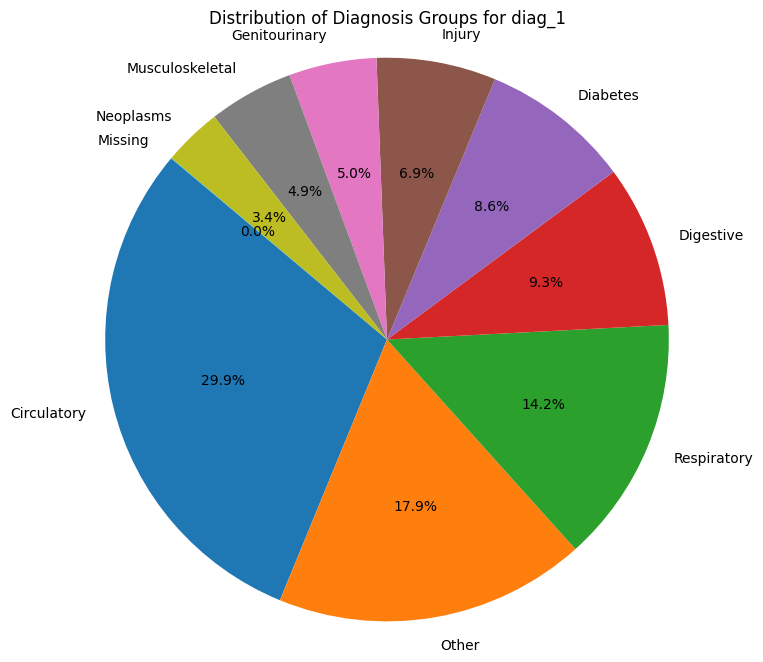

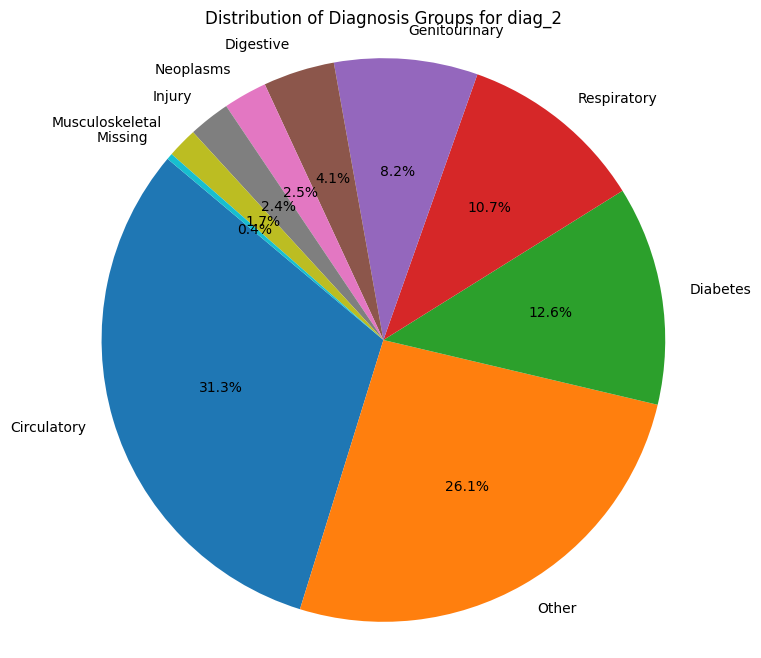

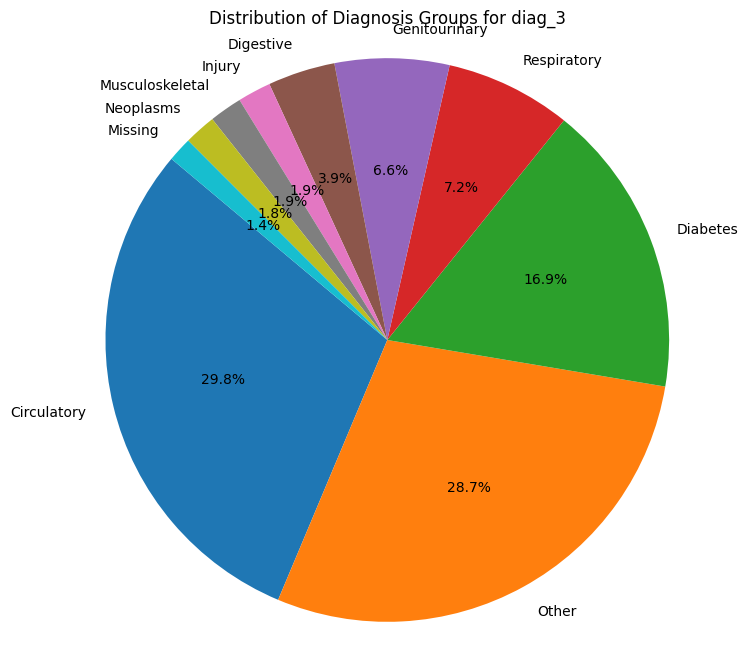

In [245]:
# Diagnosen in diag_1, diag_2 und diag_3 ersetzen und zählen
for col in ['diag_1', 'diag_2', 'diag_3']:
    data[col+'_grouped'] = data[col].apply(group_diagnosis)
    diagnosis_counts = data[col+'_grouped'].value_counts()

    # Pie Chart erstellen
    plt.figure(figsize=(8, 8))
    plt.pie(diagnosis_counts, labels=diagnosis_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of Diagnosis Groups for {col}')
    plt.axis('equal')
    plt.show()


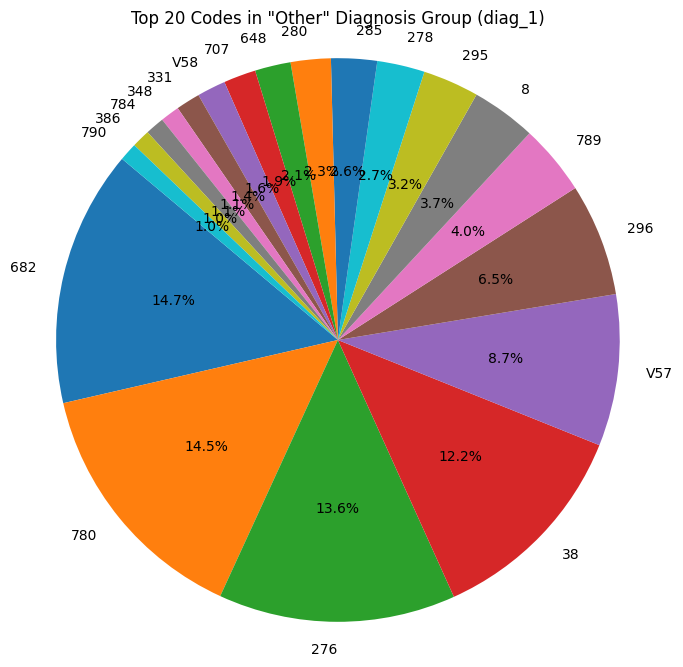

In [246]:
# Zähle die Häufigkeit der Codes in der Gruppe "Other"
other_diagnoses = data[data['diag_1_grouped'] == 'Other']['diag_1']
other_diagnoses_counts = other_diagnoses.value_counts()
# Top 20 Codes in der Gruppe "Other" auswählen
top_20_other_diagnoses = other_diagnoses_counts.head(20)

# Pie Chart für die Top 20 Codes in der Gruppe "Other" erstellen
plt.figure(figsize=(8, 8))
plt.pie(top_20_other_diagnoses, labels=top_20_other_diagnoses.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 20 Codes in "Other" Diagnosis Group (diag_1)')
plt.axis('equal')
plt.show()



## Patients with multiple encounters in dataset

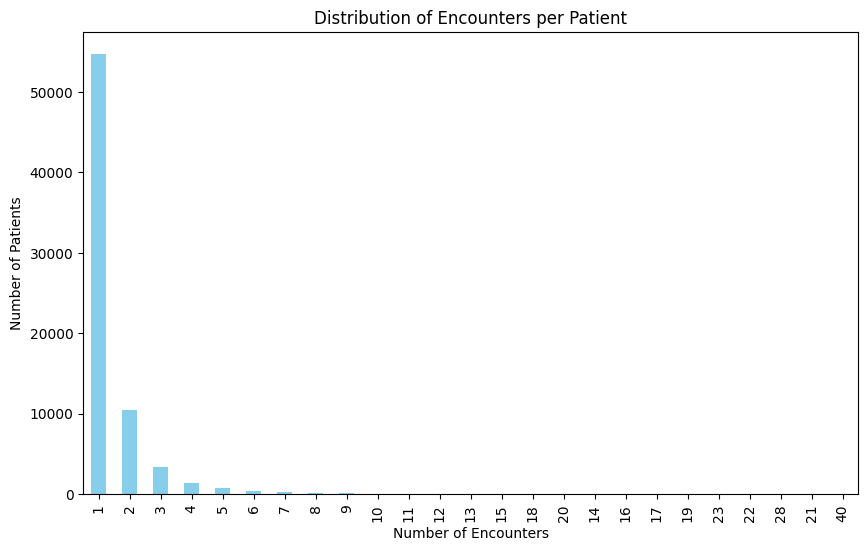

In [247]:
# Anzahl der Encounters pro Patient zählen
encounters_per_patient = data['patient_nbr'].value_counts()

# Barchart erstellen
plt.figure(figsize=(10, 6))
encounters_per_patient.value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Number of Encounters')
plt.ylabel('Number of Patients')
plt.title('Distribution of Encounters per Patient')
plt.show()


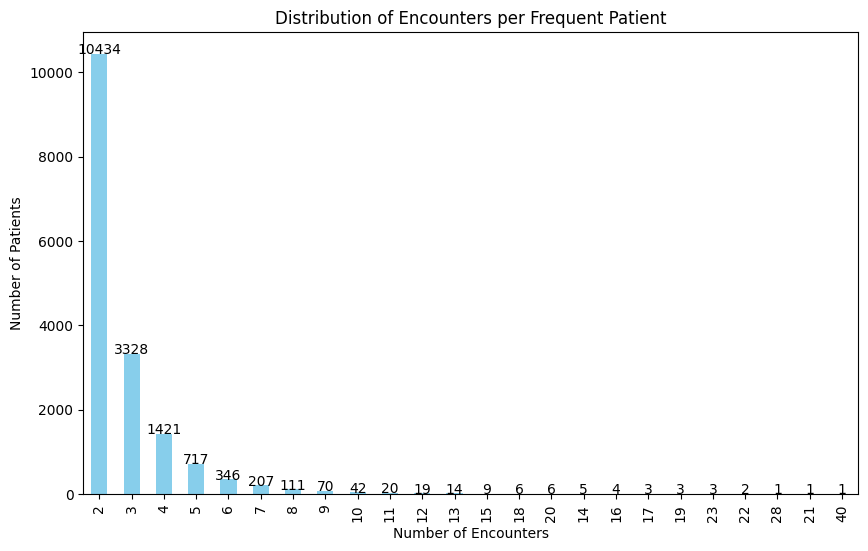

In [248]:
# Anzahl der Encounters pro Patient zählen
encounters_per_patient = data['patient_nbr'].value_counts()

# Nur Patienten auswählen, die mehr als einen Encounter haben
frequent_patients = encounters_per_patient[encounters_per_patient > 1]

# Barchart erstellen
plt.figure(figsize=(10, 6))
ax = frequent_patients.value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Number of Encounters')
plt.ylabel('Number of Patients')
plt.title('Distribution of Encounters per Frequent Patient')

# Text über den Balken anzeigen
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.1, str(int(i.get_height())), ha='center', color='black')

plt.show()


## Medications of patients with diabetes


In [249]:
data

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_grouped,diag_2_grouped,diag_3_grouped
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Diabetes,Missing,Missing
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Other,Diabetes,Other
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Other,Diabetes,Other
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Other,Diabetes,Circulatory
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Neoplasms,Neoplasms,Diabetes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,MC,NaN,51,0,16,0,0,0,250.13,291,458,9,NaN,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,Diabetes,Other,Circulatory
101762,443847782,74694222,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,MC,NaN,33,3,18,0,0,1,560,276,787,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,Digestive,Other,Digestive
101763,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,53,0,9,1,0,0,38,590,296,13,NaN,NaN,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO,Other,Genitourinary,Other
101764,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,45,2,21,0,0,1,996,285,998,9,NaN,NaN,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Injury,Other,Injury


In [250]:
data["metformin"]

0             No
1             No
2             No
3             No
4             No
           ...  
101761    Steady
101762        No
101763    Steady
101764        No
101765        No
Name: metformin, Length: 101766, dtype: object

In [251]:
medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
# 1. Medikamente verarbeiten
for m in medications:
    data[m] = np.where(data[m]=='No', 0, 1)

In [252]:
data

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_grouped,diag_2_grouped,diag_3_grouped
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,0,0,0,0,0,0,No,No,NO,Diabetes,Missing,Missing
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,1,0,0,0,0,0,Ch,Yes,>30,Other,Diabetes,Other
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,No,No,0,0,0,0,0,0,No,Yes,NO,Other,Diabetes,Other
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,1,0,0,0,0,0,Ch,Yes,NO,Other,Diabetes,Circulatory
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,No,No,1,0,0,0,0,0,Ch,Yes,NO,Neoplasms,Neoplasms,Diabetes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,MC,NaN,51,0,16,0,0,0,250.13,291,458,9,NaN,>8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,1,0,0,0,0,0,Ch,Yes,>30,Diabetes,Other,Circulatory
101762,443847782,74694222,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,MC,NaN,33,3,18,0,0,1,560,276,787,9,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,1,0,0,0,0,0,No,Yes,NO,Digestive,Other,Digestive
101763,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,53,0,9,1,0,0,38,590,296,13,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,1,0,0,0,0,0,Ch,Yes,NO,Other,Genitourinary,Other
101764,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,45,2,21,0,0,1,996,285,998,9,NaN,NaN,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,No,No,1,0,0,0,0,0,Ch,Yes,NO,Injury,Other,Injury


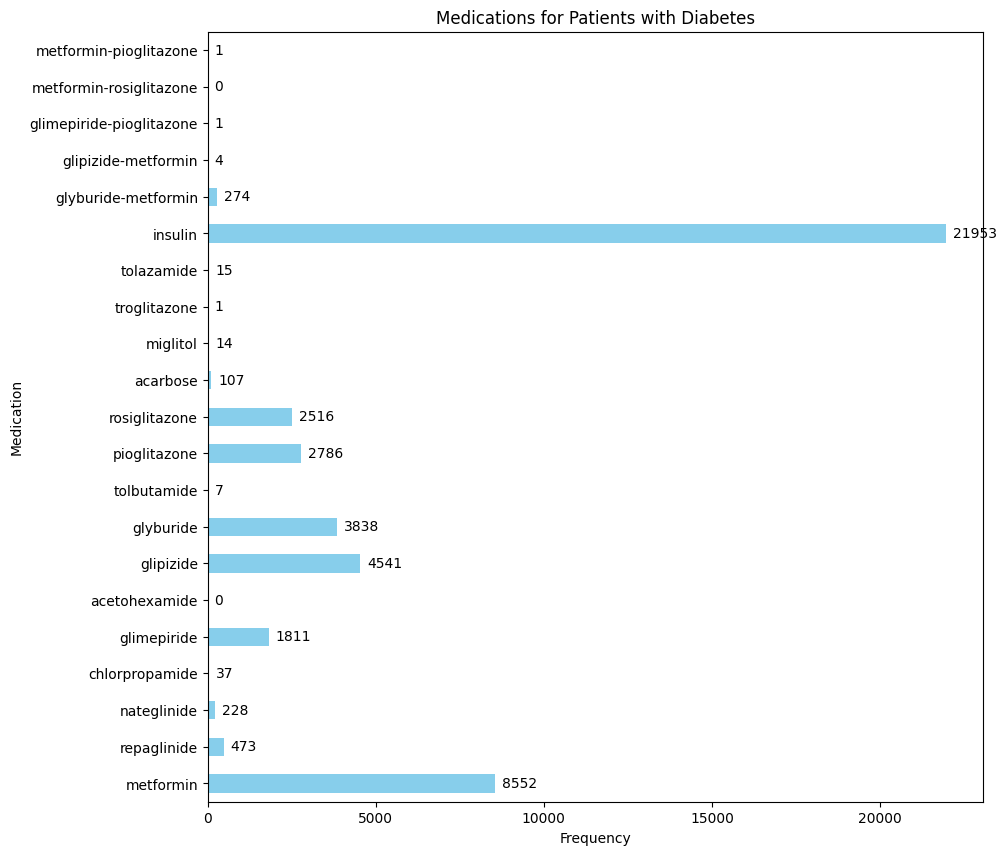

In [253]:
# 2. Filtern der Daten nach Personen mit Diabetes-Diagnosen
diabetes_patients = data[(data['diag_1_grouped'] == 'Diabetes') | (data['diag_2_grouped'] == 'Diabetes') | (data['diag_3_grouped'] == 'Diabetes')]

# 3. Zählen der Häufigkeit der Medikamentenverschreibungen
medication_counts = diabetes_patients[medications].sum()

# 4. Barchart erstellen
plt.figure(figsize=(10, 10))
bars = medication_counts.plot(kind='barh', color='skyblue')
plt.title('Medications for Patients with Diabetes')
plt.xlabel('Frequency')
plt.ylabel('Medication')

# Zahlen neben den Balken anzeigen
for bar in bars.patches:
    plt.annotate(format(bar.get_width(), '.0f'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='left',
                 va='center',
                 xytext=(5, 0),
                 textcoords='offset points')


plt.show()



## Diagnoses that occur together with Diabetes

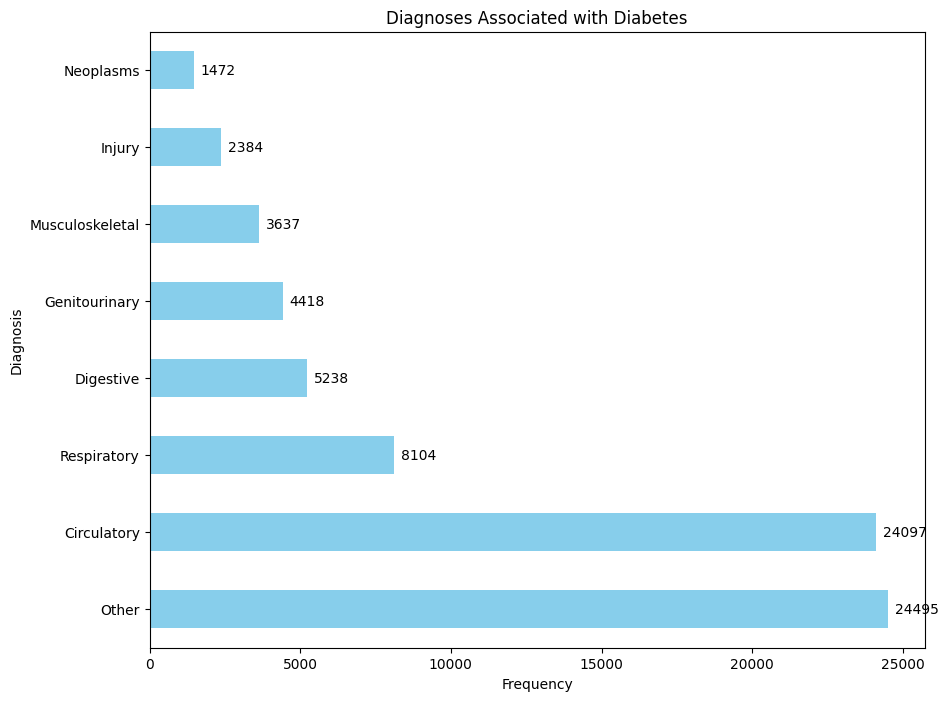

In [254]:
# Filtern der Daten nach Personen mit Diabetes-Diagnosen
diabetes_patients = data[(data['diag_1_grouped'] == 'Diabetes') | (data['diag_2_grouped'] == 'Diabetes') | (data['diag_3_grouped'] == 'Diabetes')]

# Extrahieren der Diagnosen aus den drei Spalten für Diabetes-Patienten
diagnosis_combinations = diabetes_patients[['diag_1_grouped', 'diag_2_grouped', 'diag_3_grouped']]

# Zusammenführen der Diagnosen in einer einzigen Spalte
diagnosis_combinations_stacked = diagnosis_combinations.stack()

# Zählen der Häufigkeit jeder Diagnose
diagnosis_counts = diagnosis_combinations_stacked.value_counts()

# Entfernen der Diagnose "Diabetes" aus den Zählungen
diagnosis_counts = diagnosis_counts.drop('Diabetes', errors='ignore')
diagnosis_counts = diagnosis_counts.drop('Missing', errors='ignore')

# Erstellen der horizontalen Barchart
plt.figure(figsize=(10, 8))
bars = diagnosis_counts.plot(kind='barh', color='skyblue')
plt.title('Diagnoses Associated with Diabetes')
plt.xlabel('Frequency')
plt.ylabel('Diagnosis')

# Zahlen neben den Balken anzeigen
for bar in bars.patches:
    plt.annotate(format(bar.get_width(), '.0f'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='left',
                 va='center',
                 xytext=(5, 0),
                 textcoords='offset points')

plt.show()


## Target value 'readmitted'

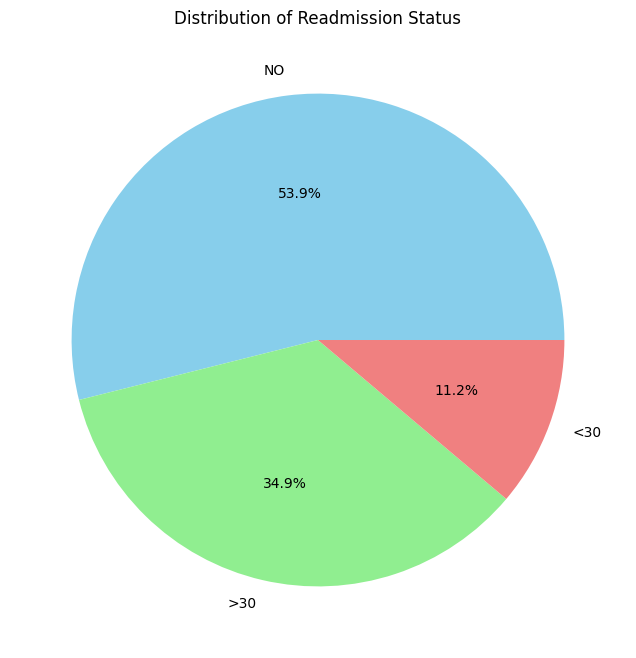

In [255]:
# Zählen der Häufigkeit jeder Klasse
readmitted_counts = data['readmitted'].value_counts()

# Erstellen der Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(readmitted_counts, labels=readmitted_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Distribution of Readmission Status')
plt.show()


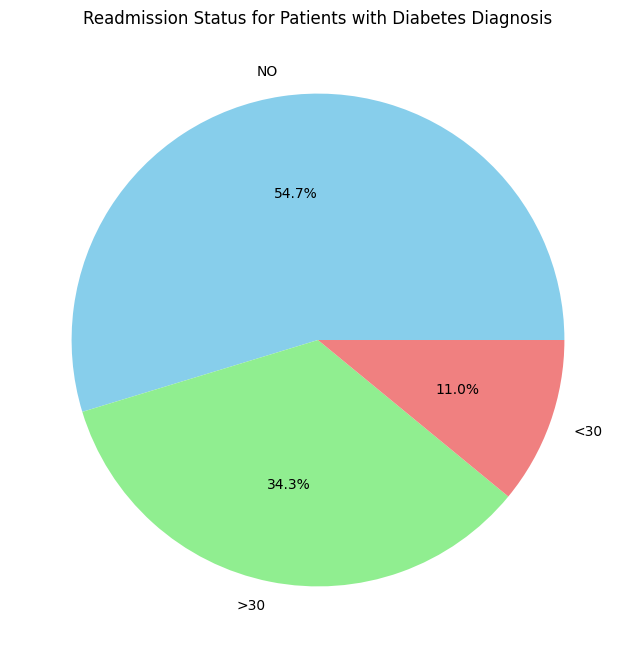

In [256]:
# Filtern der Daten nach Personen mit Diabetes-Diagnosen
diabetes_patients = data[(data['diag_1_grouped'] == 'Diabetes') | (data['diag_2_grouped'] == 'Diabetes') | (data['diag_3_grouped'] == 'Diabetes')]

# Zählen der Häufigkeit der Werte von "readmitted" für diese Personen
readmitted_counts_diabetes = diabetes_patients['readmitted'].value_counts()

# Erstellen einer Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(readmitted_counts_diabetes, labels=readmitted_counts_diabetes.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Readmission Status for Patients with Diabetes Diagnosis')
plt.show()


## Correlation matrix without encoding

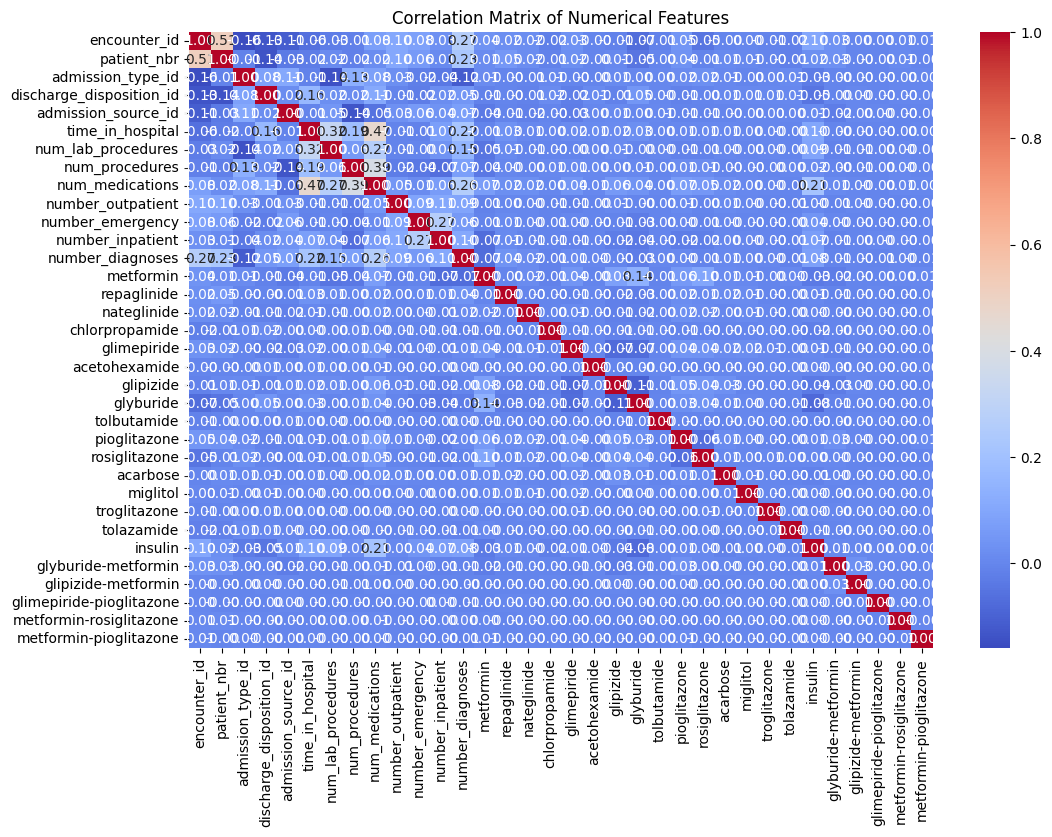

In [257]:
# Numerische Spalten auswählen
numerical_data = data.select_dtypes(include='number')

# Korrelationsmatrix erstellen
correlation_matrix = numerical_data.corr()

# Plot der Korrelationsmatrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()


## Correlation matrix with encoding of a few small features
No One Hot Encoding, just simple encoding of features that can be binary encoded or something similar.

In [258]:
# For max_glu_serum and A1Cresult the categorical value None got replace with np.nan while fetching the data and reading it as a DataFrame
# these have to be replaced by categorical values again. In This case np.nan gets replaced with 'No', to be consitent with drug presciptiosn
data[['max_glu_serum', 'A1Cresult']] = data[['max_glu_serum', 'A1Cresult']].fillna(value='No')

# Encode 'max_glu_serum' and 'A1Cresult'
max_glu_serum_encodings = {'No' : 0, 'Norm' : 1, '>200': 2, '>300' : 3}
A1Cresult_encodings = {'No' : 0, 'Norm' :1, '>7' : 2, '>8' : 3}

data['max_glu_serum'] = data['max_glu_serum'].map(max_glu_serum_encodings)
data['A1Cresult'] = data['A1Cresult'].map(A1Cresult_encodings)

In [259]:
data.drop(data[data["gender"] == "Unknown/Invalid"].index, inplace=True)
# Binary encoding of gender
gender = {"Male": 0, "Female": 1}
data["gender"] = data["gender"].map(gender)

In [260]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data["age_label"] = label_encoder.fit_transform(data["age"])

data.drop("age", axis=1, inplace=True)

In [261]:
diabetesMed_map = {'Yes': 1, 'No': 0}
data["diabetesMed"] = data["diabetesMed"].map(diabetesMed_map)


In [262]:
change_map = {"No": 0, "Ch": 1}
data["change"] = data["change"].map(change_map)


In [263]:
data['readmitted'] = data['readmitted'].replace({'NO': 0, '>30': 0, '<30': 1})
data

,encounter_id,patient_nbr,race,gender,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_grouped,diag_2_grouped,diag_3_grouped,age_label
0,2278392,8222157,Caucasian,1,NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,0,0,0,0,0,0,0,0,0,Diabetes,Missing,Missing,0
1,149190,55629189,Caucasian,1,NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,1,0,0,0,0,0,1,1,0,Other,Diabetes,Other,1
2,64410,86047875,AfricanAmerican,1,NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,No,No,0,0,0,0,0,0,0,1,0,Other,Diabetes,Other,2
3,500364,82442376,Caucasian,0,NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,1,0,0,0,0,0,1,1,0,Other,Diabetes,Circulatory,3
4,16680,42519267,Caucasian,0,NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,No,No,1,0,0,0,0,0,1,1,0,Neoplasms,Neoplasms,Diabetes,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,0,NaN,1,3,7,3,MC,NaN,51,0,16,0,0,0,250.13,291,458,9,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,1,0,0,0,0,0,1,1,0,Diabetes,Other,Circulatory,7
101762,443847782,74694222,AfricanAmerican,1,NaN,1,4,5,5,MC,NaN,33,3,18,0,0,1,560,276,787,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,1,0,0,0,0,0,0,1,0,Digestive,Other,Digestive,8
101763,443854148,41088789,Caucasian,0,NaN,1,1,7,1,MC,NaN,53,0,9,1,0,0,38,590,296,13,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,1,0,0,0,0,0,1,1,0,Other,Genitourinary,Other,7
101764,443857166,31693671,Caucasian,1,NaN,2,3,7,10,MC,Surgery-General,45,2,21,0,0,1,996,285,998,9,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,No,No,1,0,0,0,0,0,1,1,0,Injury,Other,Injury,8


In [264]:
# Numerische Spalten auswählen
numerical_data = data.select_dtypes(include='number')

# Korrelationsmatrix erstellen
correlation_matrix = numerical_data.corr()
correlation_matrix

# Plot der Korrelationsmatrix
#plt.figure(figsize=(12, 8))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
#plt.title('Correlation Matrix of Numerical Features')
#plt.show()


,encounter_id,patient_nbr,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,age_label
encounter_id,1.000000,0.512038,-0.006000,-0.158948,-0.132916,-0.112416,-0.062234,-0.026081,-0.014214,0.076121,0.103759,0.082805,0.030967,0.265147,-0.137387,-0.008192,0.036669,0.023560,0.020428,-0.020804,0.031558,-0.002410,-0.012829,-0.070696,-0.009704,0.046246,-0.049846,-0.000542,0.001530,-0.008678,-0.018123,0.101170,0.034114,0.000593,0.002089,0.006630,0.007285,0.096378,0.051828,-0.008516,0.071716
patient_nbr,0.512038,1.000000,-0.006635,-0.011131,-0.136838,-0.032558,-0.024085,0.015965,-0.015598,0.020655,0.103386,0.062357,0.012490,0.226872,-0.077275,-0.016008,0.013562,0.052175,0.019402,-0.011184,0.024606,-0.002662,0.007468,-0.049857,-0.002469,0.039361,-0.006822,0.011812,0.006929,-0.001960,-0.014644,0.024474,0.029793,-0.003550,-0.001050,0.009475,-0.001052,0.054826,0.017225,0.007900,0.070982
gender,-0.006000,-0.006635,1.000000,-0.014616,0.020925,0.003827,0.029901,0.003061,-0.059919,0.022030,0.011456,0.021064,0.014599,0.003341,0.002668,-0.023598,-0.001689,0.005431,0.005013,-0.004228,-0.001137,0.002907,-0.026759,-0.032738,-0.000478,-0.004423,-0.012641,-0.012049,-0.006558,-0.005855,-0.007015,-0.001004,-0.003692,-0.006956,0.002907,-0.004780,0.002907,-0.014870,-0.015926,0.002908,0.050575
admission_type_id,-0.158948,-0.011131,-0.014616,1.000000,0.083513,0.106668,-0.012492,-0.143701,0.129879,0.079527,0.026509,-0.019118,-0.038165,-0.117121,0.356502,-0.042306,0.014871,-0.003340,-0.008691,0.007939,-0.001566,-0.002221,0.012685,0.002670,0.003821,0.015387,0.022355,0.005273,-0.000673,0.002414,0.008706,-0.031513,-0.003273,-0.004399,-0.002221,-0.000074,0.002117,0.007268,-0.000323,-0.011654,-0.007209
discharge_disposition_id,-0.132916,-0.136838,0.020925,0.083513,1.000000,0.018179,0.162708,0.023378,0.015919,0.108738,-0.008709,-0.024468,0.020801,0.046852,0.041519,-0.021096,-0.010574,-0.004166,-0.012044,0.016619,-0.021784,0.010856,-0.013761,0.045453,0.001801,-0.012712,-0.005062,0.005713,0.007977,0.006463,0.008187,-0.046613,-0.004488,0.000444,-0.001612,-0.000181,-0.000425,-0.012344,-0.028914,0.050572,0.114314
admission_source_id,-0.112416,-0.032558,0.003827,0.106668,0.018179,1.000000,-0.006979,0.048862,-0.135380,-0.054524,0.027243,0.059891,0.036312,0.072098,0.415256,0.005630,-0.035862,-0.005094,-0.016797,-0.003152,-0.027632,0.000961,0.009770,0.003902,0.005895,-0.007295,-0.009481,-0.001117,-0.000209,0.001664,0.001801,0.012648,-0.024197,-0.000387,0.000961,-0.001914,-0.003667,0.002447,0.001510,0.005818,0.044702
time_in_hospital,-0.062234,-0.024085,0.029901,-0.012492,0.162708,-0.006979,1.000000,0.318429,0.191497,0.466137,-0.008919,-0.009683,0.073619,0.220153,0.028231,0.055886,-0.006548,0.033704,0.005350,0.002146,0.015086,0.010086,0.016349,0.025374,0.003042,0.005506,0.005680,0.006054,0.001696,0.003524,-0.003102,0.099035,-0.002165,-0.000626,-0.002516,-0.000588,0.001684,0.109166,0.062502,0.044197,0.107516
num_lab_procedures,-0.026081,0.015965,0.003061,-0.143701,0.023378,0.048862,0.318429,1.000000,0.058105,0.268176,-0.007606,-0.002282,0.039225,0.152737,-0.128381,0.238170,-0.047752,0.012545,-0.006328,-0.002084,-0.000549,0.003968,0.013581,-0.001303,0.001023,-0.013715,-0.010418,0.000050,-0.004205,0.003745,-0.000606,0.093406,-0.011004,-0.007524,-0.000812,0.001218,-0.003202,0.063970,0.033110,0.020359,0.020777
num_procedures,-0.014214,-0.015598,-0.059919,0.129879,0.015919,-0.135380,0.191497,0.058105,1.000000,0.385761,-0.024813,-0.038175,-0.066226,0.073769,-0.069275,-0.011750,-0.03973

In [265]:
# Durchlaufe die Korrelationsmatrix
for column in correlation_matrix.columns:
    for index, value in correlation_matrix[column].items():
        # Überprüfe, ob der Wert größer als 0.3 und ob es sich nicht um die Diagonale handelt
        if abs(value) > 0.3 and column != index:
            print(f"{column}, {index}: {value:.2f}")


encounter_id, patient_nbr: 0.51
patient_nbr, encounter_id: 0.51
admission_type_id, max_glu_serum: 0.36
admission_source_id, max_glu_serum: 0.42
time_in_hospital, num_lab_procedures: 0.32
time_in_hospital, num_medications: 0.47
num_lab_procedures, time_in_hospital: 0.32
num_procedures, num_medications: 0.39
num_medications, time_in_hospital: 0.47
num_medications, num_procedures: 0.39
max_glu_serum, admission_type_id: 0.36
max_glu_serum, admission_source_id: 0.42
metformin, change: 0.32
insulin, change: 0.51
insulin, diabetesMed: 0.59
change, metformin: 0.32
change, insulin: 0.51
change, diabetesMed: 0.51
diabetesMed, insulin: 0.59
diabetesMed, change: 0.51
